In [22]:
!pip install -q imutils
!pip install -q plotly

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [43]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import tensorflow as tf

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D

## Load data and define hyperparameters

In [21]:
EPOCHS = 10
SAMPLE_LEN = 100

df = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

# EDA

### Statuses:

In [20]:
df.columns.values[1:]

array(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype=object)

### Explore data

In [4]:
df.head(5)

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [5]:
data = df.copy()
data['filename'] = data['image_id'] + '.jpg'
data['class'] = data[data.columns[1:5]].apply(lambda x:
                                             'healthy' if x['healthy'] == 1
                                            else 'multiple_diseases' if x['multiple_diseases'] == 1
                                            else 'rust' if x['rust'] == 1
                                            else 'scab',
                                             axis=1)
data = data.drop(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], axis=1)

In [6]:
data.head(5)

filename              class
0  Train_0.jpg               scab
1  Train_1.jpg  multiple_diseases
2  Train_2.jpg            healthy
3  Train_3.jpg               rust
4  Train_4.jpg            healthy

In [28]:
def load_image(filename):
    path = 'dataset/images/{0}'.format(filename)
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [37]:
train_images = data['filename'][:SAMPLE_LEN].apply(load_image)

### Load one leaf

In [40]:
fig = px.imshow(cv2.resize(train_images[0], (205, 136)))
fig.show()

### Load multiple leafs

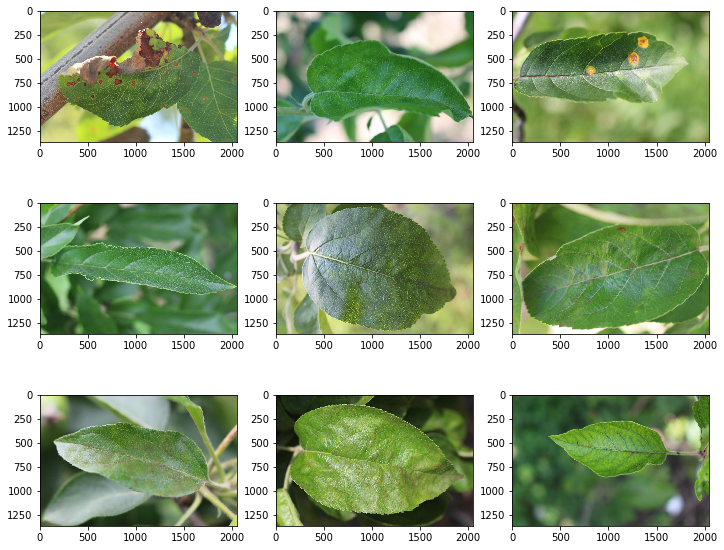

In [34]:
element = 1
fig, ax = plt.subplots(3, 3, figsize=(12, 10))

for i in range(3):
    for j in range(3):
        image = load_image(data.loc[element]['filename'])
        ax[i, j].imshow(image)
        element += 1

In [41]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

In [44]:
fig = ff.create_distplot([values], group_labels=['Channels'], colors=['purple'])
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of channel values')
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [50]:
fig = ff.create_distplot([red_values], group_labels=['Channels'], colors=['red'])
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of channel values')
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [51]:
fig = ff.create_distplot([green_values], group_labels=['Channels'], colors=['green'])
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of channel values')
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [52]:
fig = ff.create_distplot([blue_values], group_labels=['Channels'], colors=['blue'])
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of channel values')
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [53]:
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [8]:
image_gen = ImageDataGenerator(rotation_range=90,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               brightness_range=(1, 1.2),
                               rescale=1./255,
                               shear_range=0.3,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.2)

In [9]:
np.random.seed(5)
batch_size = 16
image_shape = (200, 200, 3)
directory = 'dataset/images'

train_data = image_gen.flow_from_dataframe(data,
                                           directory,
                                           target_size=image_shape[:2],
                                           batch_size=batch_size,
                                           subset='training')
test_data = image_gen.flow_from_dataframe(data,
                                          directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          subset='validation')

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


In [10]:
# plt.imshow(train_data)

def show_batch_img(batch, nrows=3, ncols=3):
    element = 0
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 16))
    for i in range(nrows):
        for j in range(ncols):
            ax[i][j].imshow(batch[element])
            element += 1
    plt.show()

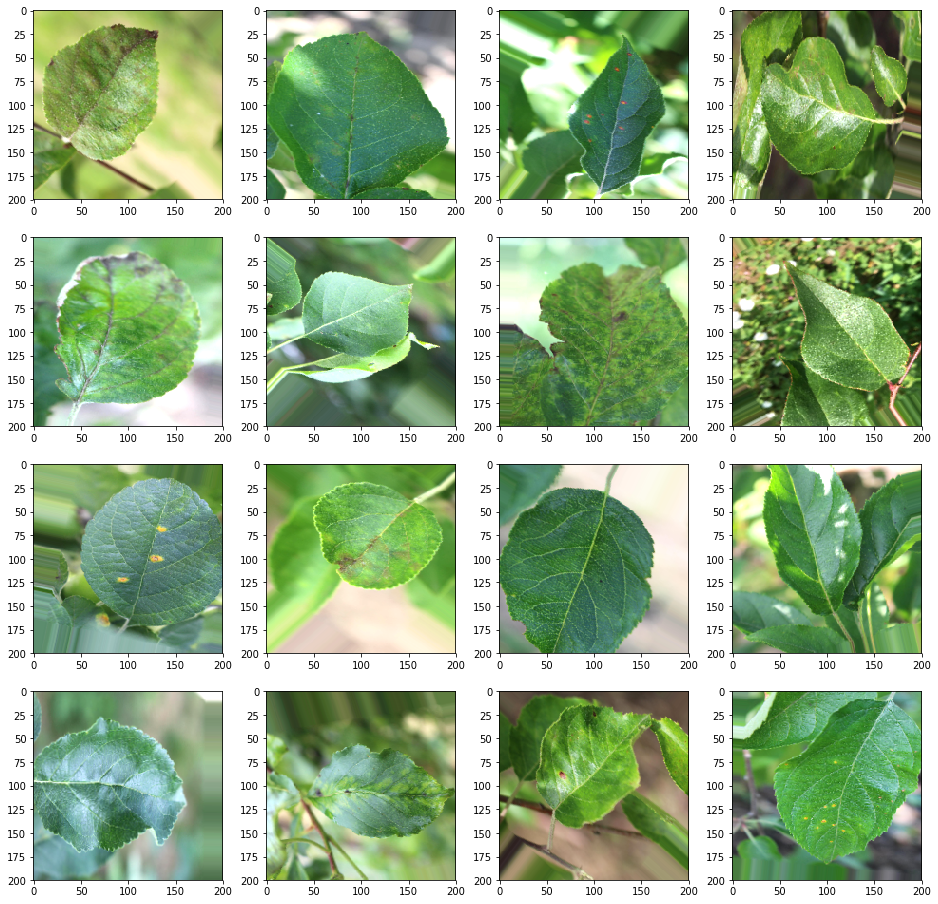

In [11]:
show_batch_img(train_data[0][0], 4, 4)

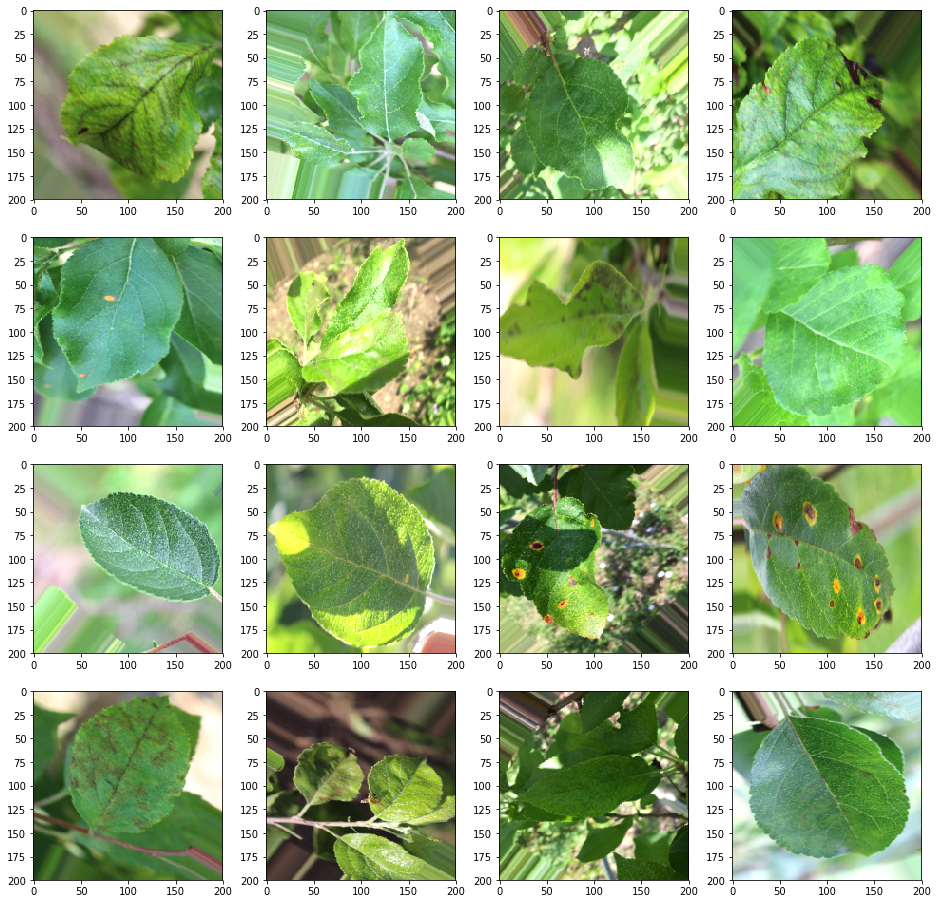

In [12]:
show_batch_img(train_data[1][0], 4, 4)

In [13]:
base_model = MobileNetV2(input_shape=image_shape,
                         include_top=False,
                         weights='imagenet')

/usr/local/lib/python3.5/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 10s 1us/step


In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 201, 201, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 100, 100, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 100, 100, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [30]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4)
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=[categorical_accuracy])

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
results = model.fit_generator(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=test_data.samples//batch_size,
                              steps_per_epoch=train_data.samples//batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 91 steps, validate for 22 steps
Epoch 1/10
91/91 [==============================] - 57s 622ms/step - loss: 3.0327 - categorical_accuracy: 0.2804 - val_loss: 3.5999 - val_categorical_accuracy: 0.3068
Epoch 2/10
91/91 [==============================] - 54s 598ms/step - loss: 2.7567 - categorical_accuracy: 0.3151 - val_loss: 4.3329 - val_categorical_accuracy: 0.3182
Epoch 3/10
91/91 [==============================] - 54s 595ms/step - loss: 2.7729 - categorical_accuracy: 0.3414 - val_loss: 4.1086 - val_categorical_accuracy: 0.3239
Epoch 4/10
91/91 [==============================] - 55s 610ms/step - loss: 2.8638 - categorical_accuracy: 0.3324 - val_loss: 4.3346 - val_categorical_accuracy: 0.3011
Epoch 5/10
91/91 [==============================] - 56s 617ms/step - loss: 2.7323 - categorical_accuracy: 0.3629 - val_loss: 3.9592 - val_categorical_accuracy: 0.3153
Epoch 6/10
91/91 [==============================] - 56s 616ms/step - loss